# Emulator based retrievals without considering effect of clouds

First see how well the off angle spectra compare with the closest match from the angle sets we have....

In [51]:
# compare the off angle spectra with simulations close to it
import glob

# load the filename list
fns = glob.glob('../../Data/LUT/lhd1000_valid_ap_realistic/*.p')

pars = []
for i, f in enumerate(fns):
    f = f.split('_')
    f[-1] = f[-1].split('.p')[0]
    f[-6] = f[-6].split('/')[-1]
    f = f[3:]
    f[0] = f[0].split('/')[1]
    pars.append(f)
    # uncomment below to see files
    #print 'file nr: %d' % i
    #print 'sza: %s, vza: %s, raa: %s, alt: %s km, AOT: %s, WVC: %s kg/m2, press: %s hPa, a: %s, p: %s' % tuple(f)

sza: 37, vza: 6, raa: 7, alt: 1.94569968 km, AOT: 0.06630694, WVC: 9.59345389 kg/m2, press: 1026.87602539 hPa, a: 0.29276680, p: 0.691692


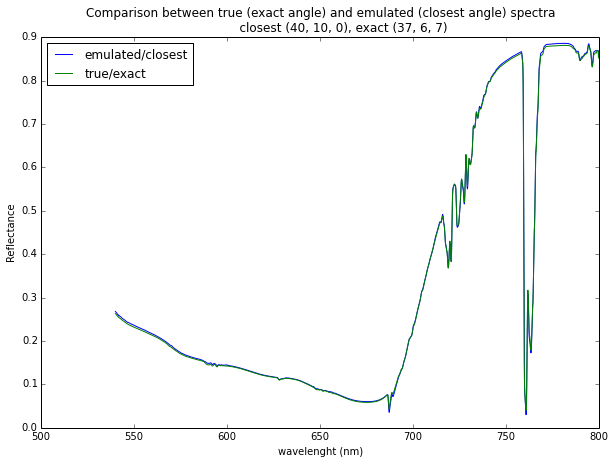

In [52]:
# select one file and compare with closest emulator in angle space
import gp_emulator
import h5py
import pickle

h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators.h5'
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')

filenr = 6

sza, vza, raa, alt, AOT, WVC, press, a, p = pars[filenr]
print 'sza: %s, vza: %s, raa: %s, alt: %s km, AOT: %s, WVC: %s kg/m2, press: %s hPa, a: %s, p: %s' % \
    tuple(pars[filenr])

sza = int(sza)
vza = int(vza)
raa = int(raa)
alt = float(alt)
AOT = float(AOT)
WVC = float(WVC)
press = float(press)
a = float(a)
p = float(p)

# round to closest value
szar = int(round(sza, -1))
vzar = int(round(vza, -1))
raas = range(0, 195, 15)
raar = min(raas, key=lambda x:abs(x-raa))

# emulate value at closest point, and compare against true value
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)

grp = '%s_%s_%s' % (szar, vzar, raar)
grp = h5_mean[grp]
mean_toa_refl = grp['mean_toa_refl'][:]

# emulate based on above parameters and add mean spectra
y = (WVC, AOT, alt, press, a, p)
toa_refl_emu = emu.predict(y)[0] + mean_toa_refl

# load pickle and reflectance to compare
pkl = pickle.load(open(fns[filenr], 'rb'))
toa_refl = pkl['toa_refl']
lam = pkl['lam']

#plot the true and emulated spectra
%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(10,7))
plt.plot(lam, toa_refl_emu, label='emulated/closest')
plt.plot(lam, toa_refl, label='true/exact')
plt.title('Comparison between true (exact angle) and emulated (closest angle) spectra\n\
            closest %s, exact %s' % ((szar, vzar, raar), (sza, vza, raa)))
plt.legend(loc='best')
plt.xlabel('wavelenght (nm)')
plt.ylabel('Reflectance')


# Retrieve parameters with inversion

Retrieve parameters including DASF using numerical inversion....

sza: 37, vza: 6, raa: 7, alt: 1.94569968 km
--------------------------------------------------
True parameters
AOT: 0.0663, WVC:  9.5935 kg/m2, press: 1026.8760 hPa, a: 0.2928, p: 0.6917, DASF: 0.9496
--------------------------------------------------
Retrieved parameters
AOT: 0.1190, WVC:  9.1858 kg/m2, press:  999.7890 hPa, a: 0.2929, p: 0.6927, DASF: 0.9530


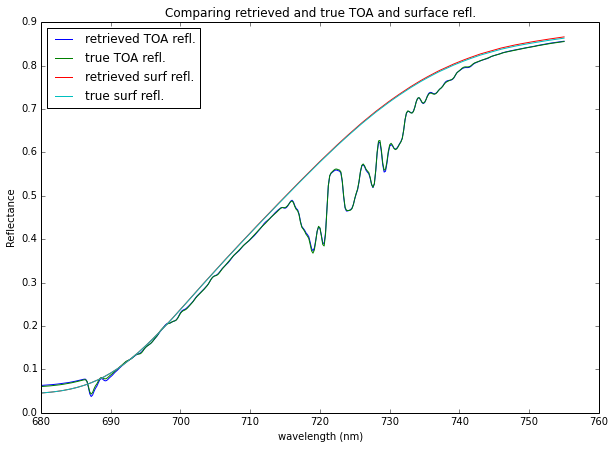

In [53]:
# minimisation

# add noise to exact spectra and see if we can retrieve the parameters
import numpy as np
from scipy.interpolate import interp1d

snr = 1000. # signal to noise ratio 2000 from Guanter et al 2014, and 1000 from Joiner 2014, Paris

# need to slice spectrum to GOME-2 red-edge range being used
wl_min = 680.
wl_max = 755.

# get wavelenght interval to approximately GOME-2 resolution
resol = 0.2 # in nm
lam_gome = np.arange(wl_min, wl_max+0.001, resol)

toa_refl_gome = (interp1d(lam, toa_refl, kind='linear'))(lam_gome)

# add the uncorrelated noise
# use convention of SNR = expected signal / std of noise
std_noise = toa_refl_gome / snr
rand_noise = np.random.normal(0., std_noise)
toa_refl_noise = toa_refl_gome + rand_noise

import gp_emulator
h5_emu = '/home/malapradej/Documents/PhD_UCL/Data/LUT/libradtran_emulators.h5'
emu = gp_emulator.MultivariateEmulator(dump=h5_emu, model='toa_refl', sza=szar, vza=vzar, raa=raar)
import h5py
h5_mean = h5py.File('/home/malapradej/Documents/PhD_UCL/Data/LUT/mean_signal.h5', 'r')

    
from scipy import optimize

def cost(paras, sza, vza, raa, alt, toa_refl_noise, lam_gome, lam_emu):
    '''The cost function to minimize
    '''
    WVC = paras[0]
    AOT = paras[1]
    press = paras[2]
    a = paras[3]
    p = paras[4]
    paras = (WVC, AOT, alt, press, a, p)
    grp = '%s_%s_%s' % (sza, vza, raa)
    grp = h5_mean[grp]
    mean_toa_refl = grp['mean_toa_refl'][:]
    toa_refl_emu = emu.predict(paras)[0] + mean_toa_refl
    # get refls to same wavelenghts
    from scipy.interpolate import interp1d
    toa_refl_pred = (interp1d(lam_emu, toa_refl_emu, kind='linear'))(lam_gome)
    sse = np.sum((toa_refl_pred - toa_refl_noise)**2.)
    return sse

args = (szar, vzar, raar, alt, toa_refl_noise, lam_gome, lam)
guess = (20., 0.1, 1000., 0.5, 0.5) # wvc, aot, press, a, p
bounds = ((0., 80.), (0., 1.), (500., 1100.), (0., 1.), (0., 1.))
solv_paras = optimize.fmin_l_bfgs_b(cost,guess,approx_grad=True,iprint=0,\
                                args=args,bounds=bounds)  

# show difference between retrieved and true parameters and plot retrieved and true spectra
WVCr = solv_paras[0][0]
AOTr = solv_paras[0][1]
pressr = solv_paras[0][2]
ar = solv_paras[0][3]
pr = solv_paras[0][4]

surf_refl_fun = lambda a, p, w: a * w / (1. - p * w)
dasf_fun = lambda a, p: a / (1. - p)

dasf_true = dasf_fun(a, p)
dasf_pred = dasf_fun(ar, pr)

print 'sza: %s, vza: %s, raa: %s, alt: %s km' % (sza, vza, raa, alt)
print '-'*50
print 'True parameters'
print 'AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % (AOT, WVC, press, a, p,\
                                                                                           dasf_true)
print '-'*50
print 'Retrieved parameters'
print 'AOT: %5.4f, WVC: %7.4f kg/m2, press: %9.4f hPa, a: %5.4f, p: %5.4f, DASF: %5.4f' % (AOTr, WVCr, pressr, ar, pr, \
                                                                                          dasf_pred)

# plot the spectra true and retrieved

toa_refl_pred = emu.predict((WVCr, AOTr, alt, pressr, ar, pr))[0] + mean_toa_refl
toa_refl_pred = (interp1d(lam, toa_refl_pred, kind='linear'))(lam_gome)
plt.figure(figsize=(10,7))
plt.plot(lam_gome, toa_refl_pred, label='retrieved TOA refl.')
plt.plot(lam_gome, toa_refl_gome, label='true TOA refl.')
leafw = np.loadtxt('leaf_spectrum.txt')
lam_leaf = leafw[:,0]
leafw = leafw[:,1] + leafw[:,2]
w = (interp1d(lam_leaf, leafw, kind='linear'))(lam_gome)
surf_refl_retr = surf_refl_fun(ar, pr, w)
surf_refl = surf_refl_fun(a, p, w)
plt.plot(lam_gome, surf_refl_retr, label='retrieved surf refl.')
plt.plot(lam_gome, surf_refl, label='true surf refl.')
plt.title('Comparing retrieved and true TOA and surface refl.')
plt.legend(loc='best')
plt.xlabel('wavelength (nm)')
plt.ylabel('Reflectance')